# Prithiv Model Explainability

## Setup: Load Model with Attention Support

In [2]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import os
import glob

# Load model and processor once
processor = AutoImageProcessor.from_pretrained("../models/prithiv")
model = AutoModelForImageClassification.from_pretrained("../models/prithiv")

# IMPORTANT: Set attention implementation to 'eager' to enable attention outputs
model.set_attn_implementation('eager')

# Collect all images from the ../res directory
img_dir = os.path.join("..", "res")
image_files = sorted([
    p for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")
    for p in glob.glob(os.path.join(img_dir, ext))
])

print(f"Found {len(image_files)} image(s) in {img_dir}:")
for p in image_files:
    print(" -", os.path.basename(p))

if not image_files:
    print("No images found. Please add images to the 'res' directory.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
We set the attention implementation for the sub-config `text_config` to `eager` without finding the associated sub-model. For this reason we could not check if the model supports it. You may encounter undefined behavior.
We set the attention implementation for the sub-config `vision_config` to `eager` without finding the associated sub-model. For this reason we could not check if the model supports it. You may encounter undefined behavior.


Found 9 image(s) in ../res:
 - attention_output.png
 - churros.jpeg
 - guacamole-baklava.png
 - guacamole.jpeg
 - hamburgers.jpg
 - huevos-rancheros.jpg
 - peking_duck.jpg
 - pizza.jpg
 - ramen.jpg


## Visualize Attention Weights (all images)

Now that we have the attention weights, let's iterate over every image in `../res` and visualize what the model focuses on.


=== Processing: attention_output.png ===
Number of attention layers: 12
Attention shape (first layer): torch.Size([1, 12, 196, 196])
Format: (batch, num_heads, seq_len, seq_len)
Patch attention shape: (195, 195)


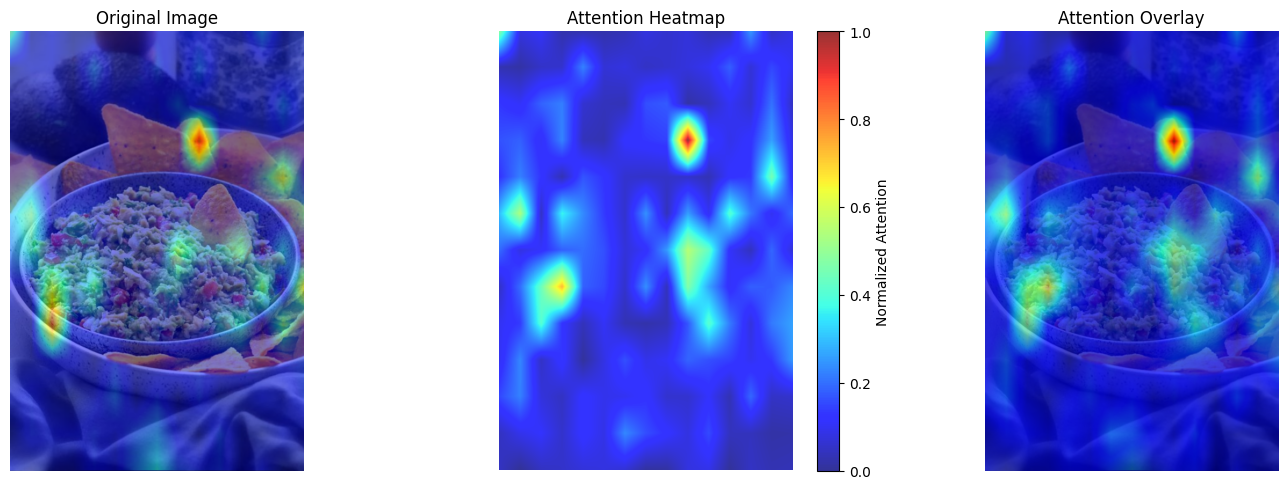


=== Processing: churros.jpeg ===
Number of attention layers: 12
Attention shape (first layer): torch.Size([1, 12, 196, 196])
Format: (batch, num_heads, seq_len, seq_len)
Patch attention shape: (195, 195)


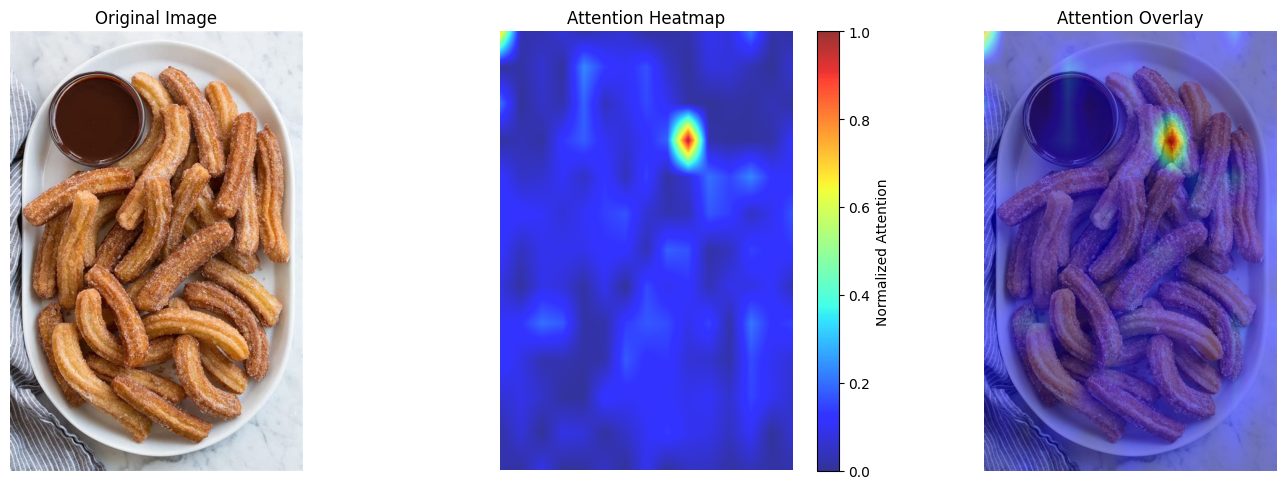


=== Processing: guacamole-baklava.png ===
Number of attention layers: 12
Attention shape (first layer): torch.Size([1, 12, 196, 196])
Format: (batch, num_heads, seq_len, seq_len)
Patch attention shape: (195, 195)


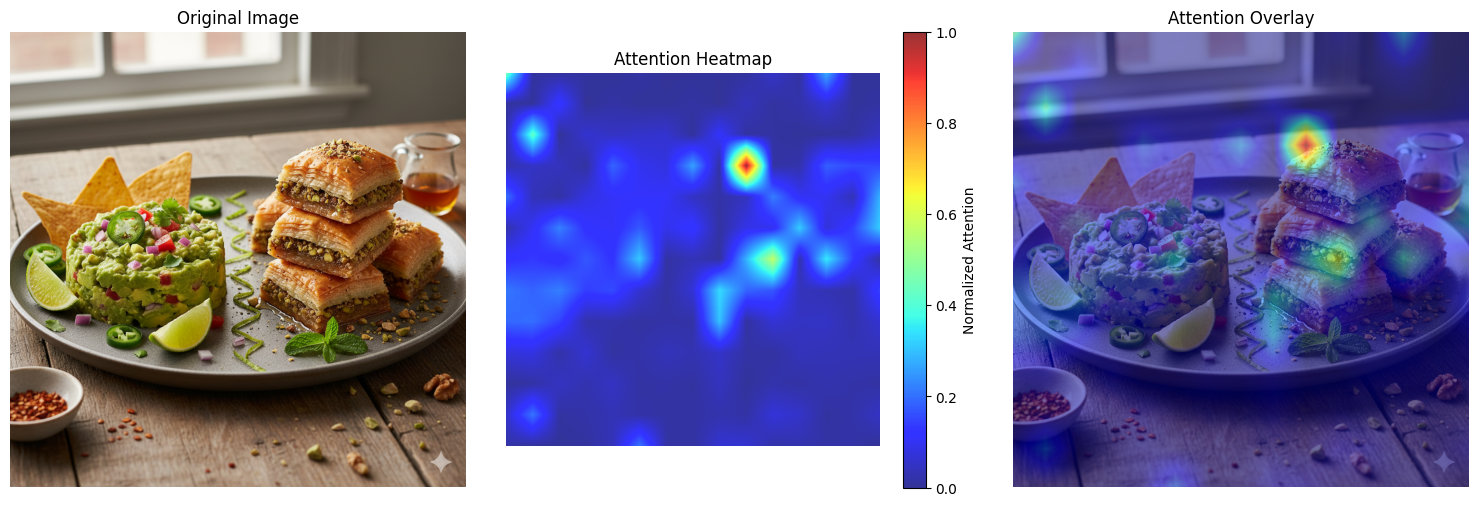


=== Processing: guacamole.jpeg ===
Number of attention layers: 12
Attention shape (first layer): torch.Size([1, 12, 196, 196])
Format: (batch, num_heads, seq_len, seq_len)
Patch attention shape: (195, 195)


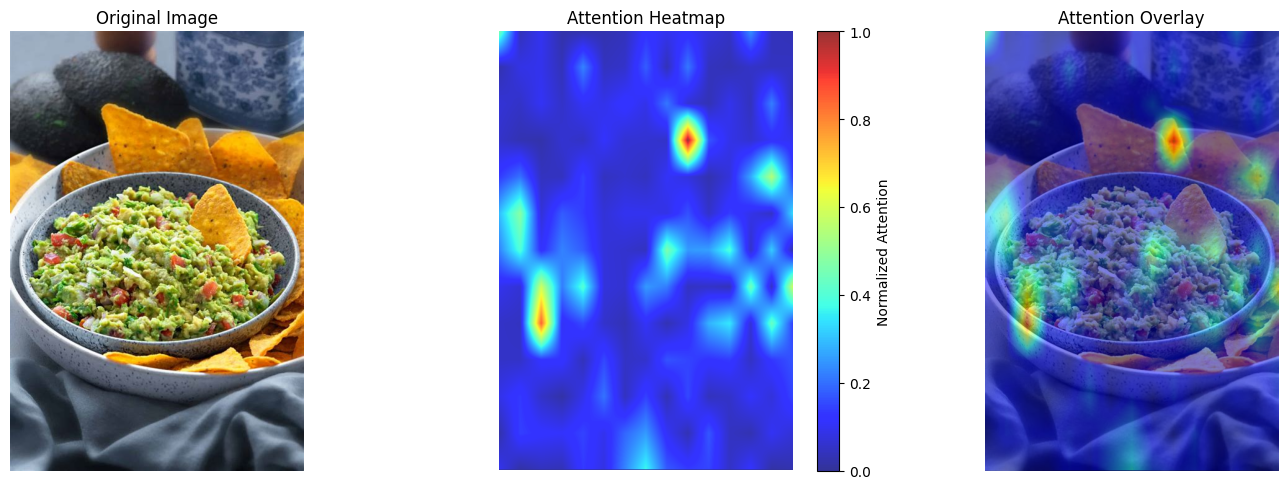


=== Processing: hamburgers.jpg ===
Number of attention layers: 12
Attention shape (first layer): torch.Size([1, 12, 196, 196])
Format: (batch, num_heads, seq_len, seq_len)
Patch attention shape: (195, 195)


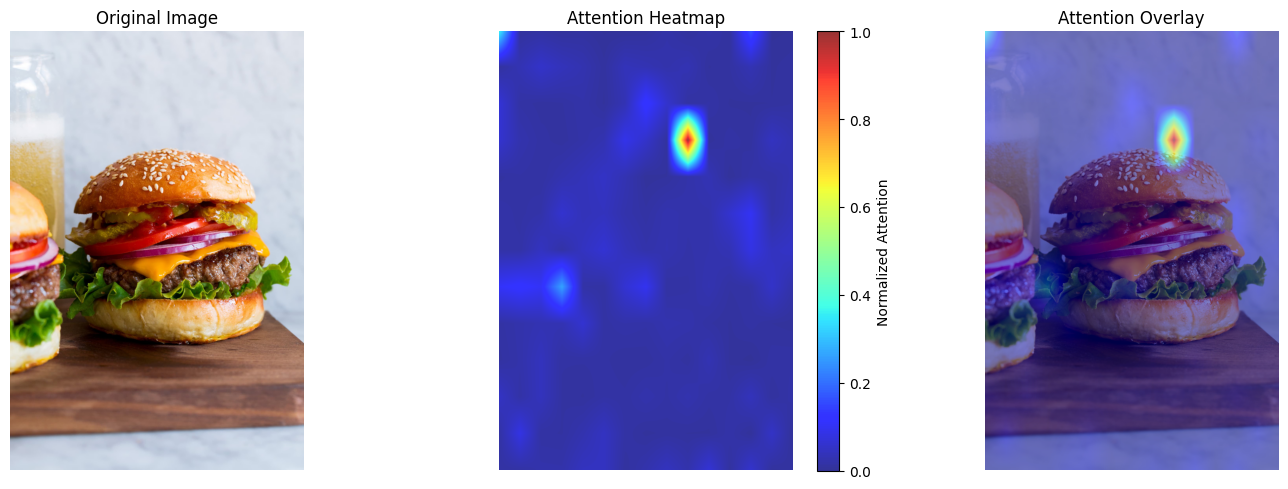


=== Processing: huevos-rancheros.jpg ===
Number of attention layers: 12
Attention shape (first layer): torch.Size([1, 12, 196, 196])
Format: (batch, num_heads, seq_len, seq_len)
Patch attention shape: (195, 195)


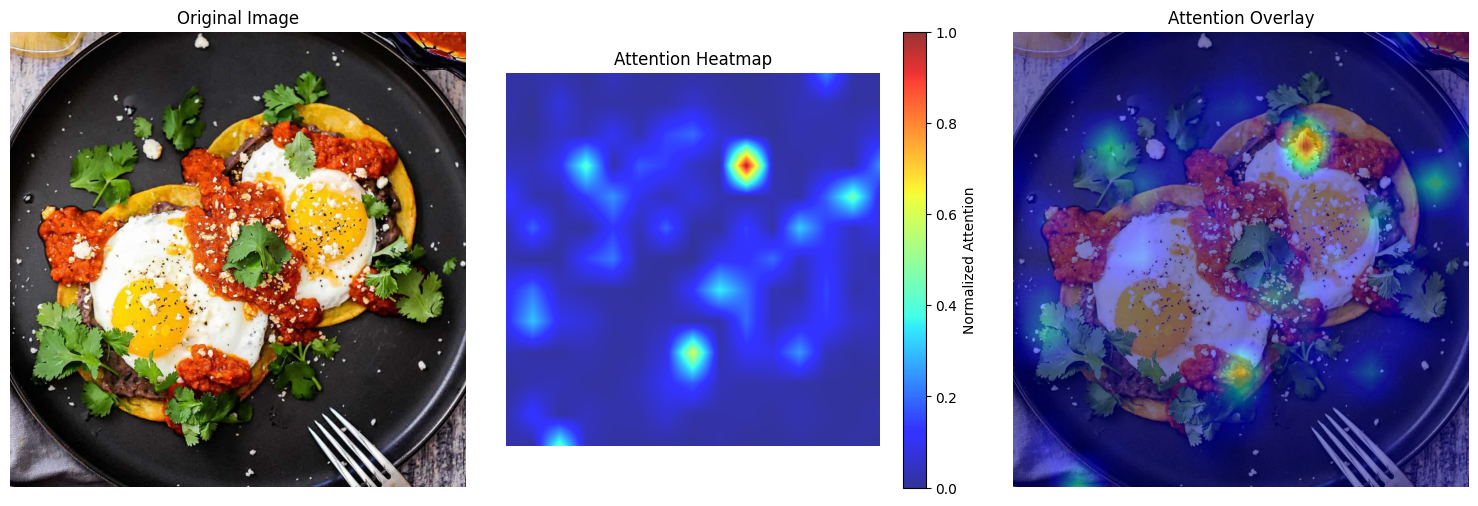


=== Processing: peking_duck.jpg ===
Number of attention layers: 12
Attention shape (first layer): torch.Size([1, 12, 196, 196])
Format: (batch, num_heads, seq_len, seq_len)
Patch attention shape: (195, 195)


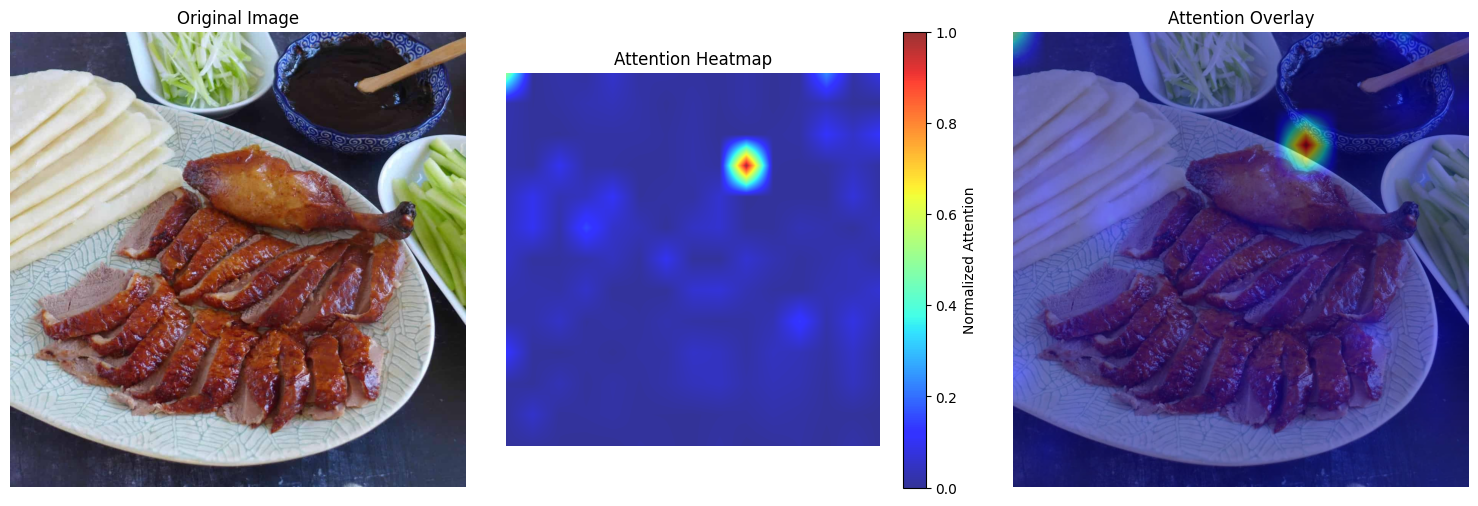


=== Processing: pizza.jpg ===
Number of attention layers: 12
Attention shape (first layer): torch.Size([1, 12, 196, 196])
Format: (batch, num_heads, seq_len, seq_len)
Patch attention shape: (195, 195)


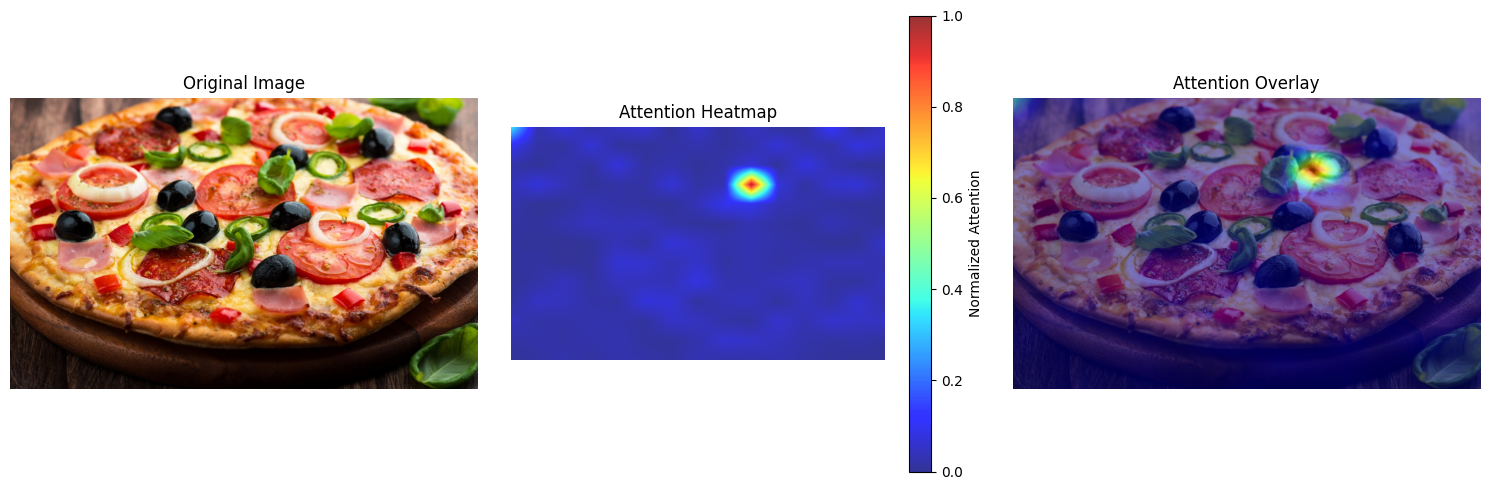


=== Processing: ramen.jpg ===
Number of attention layers: 12
Attention shape (first layer): torch.Size([1, 12, 196, 196])
Format: (batch, num_heads, seq_len, seq_len)
Patch attention shape: (195, 195)


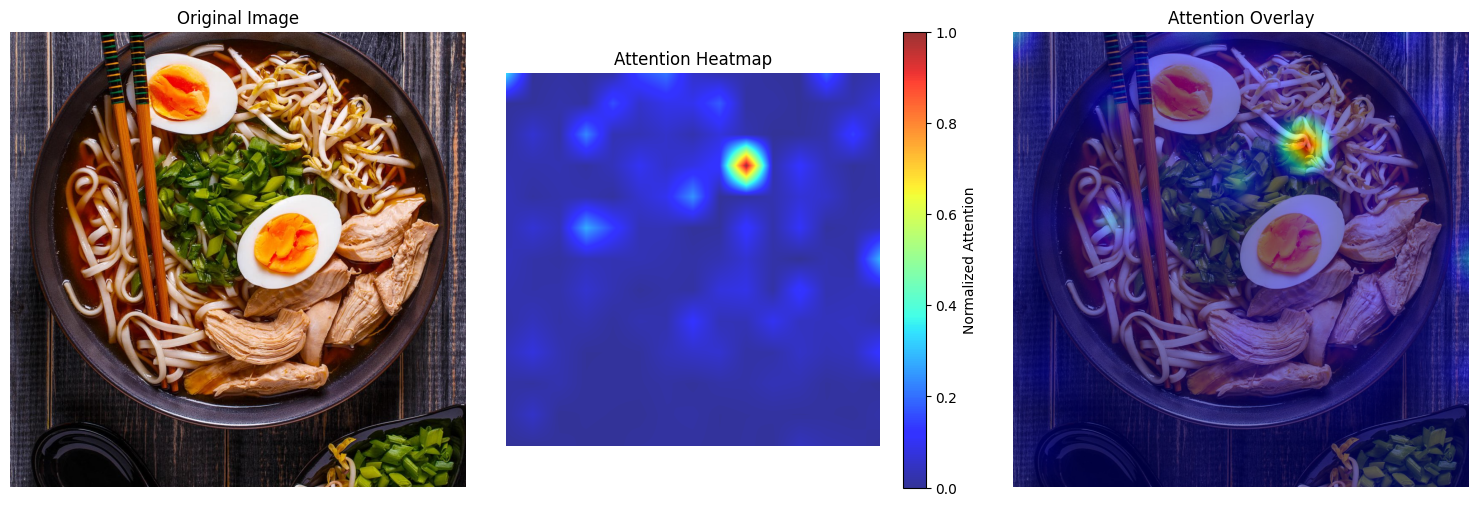

In [3]:
# Iterate over all images and visualize attention
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
from scipy.ndimage import zoom

if not 'image_files' in globals() or not image_files:
    raise RuntimeError("No images to process. Ensure the setup cell was run and images exist in ../res.")

# Helper to choose a reasonable HxW grid given number of patches
def best_grid(n: int):
    # pick factor pair with smallest |h-w|
    best = (1, n)
    for h in range(1, int(math.sqrt(n)) + 1):
        if n % h == 0:
            w = n // h
            if abs(h - w) < abs(best[0] - best[1]):
                best = (h, w)
    return best

for img_path in image_files:
    print("\n=== Processing:", os.path.basename(img_path), "===")
    image = Image.open(img_path).convert("RGB")

    # Process the image and run the model
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # The 'attentions' object is a tuple of tensors, one for each layer
    attentions = outputs.attentions
    print(f"Number of attention layers: {len(attentions) if attentions else 0}")
    if not attentions:
        continue
    print(f"Attention shape (first layer): {attentions[0].shape}")
    print("Format: (batch, num_heads, seq_len, seq_len)")

    # Average attention weights across all heads in the last layer
    # Shape: (batch, num_heads, seq_len, seq_len) -> (seq_len, seq_len)
    last_layer_attention = attentions[-1][0].mean(dim=0).detach().cpu().numpy()

    # For ViT models, the first token is usually [CLS], so skip it
    patch_attention = last_layer_attention[1:, 1:]
    print(f"Patch attention shape: {patch_attention.shape}")

    # Attention map by averaging attention received by each patch
    attention_map = patch_attention.mean(axis=0)
    n_patches = attention_map.shape[0]
    grid_h, grid_w = best_grid(n_patches)
    if grid_h * grid_w != n_patches:
        # Pad if necessary (rare)
        pad_size = grid_h * grid_w - n_patches
        attention_map = np.pad(attention_map, (0, pad_size), constant_values=0)

    attention_grid = attention_map.reshape(grid_h, grid_w)

    # # Plot original + attention map
    # plt.figure(figsize=(12, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(image)
    # plt.title('Original Image')
    # plt.axis('off')

    # plt.subplot(1, 2, 2)
    # plt.imshow(attention_grid, cmap='hot', interpolation='bilinear')
    # plt.colorbar(label='Attention Weight')
    # plt.title(f'Attention Map (Last Layer)\n{grid_h}x{grid_w} patches')
    # plt.axis('off')
    # plt.tight_layout()
    # plt.show()

    # print(f"Grid size: {grid_h}x{grid_w}")
    # print(f"Attention range: {attention_grid.min():.4f} to {attention_grid.max():.4f}")

    # Create an overlay of attention on the original image
    img_array = np.array(image)
    attention_resized = zoom(
        attention_grid,
        (img_array.shape[0] / grid_h, img_array.shape[1] / grid_w),
        order=1
    )

    # Normalize attention map to 0-1
    attention_normalized = (attention_resized - attention_resized.min())
    denom = (attention_resized.max() - attention_resized.min()) or 1.0
    attention_normalized = attention_normalized / denom

    # Create heatmap overlay
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(attention_normalized, cmap='jet', alpha=0.8)
    plt.title('Attention Heatmap')
    plt.colorbar(label='Normalized Attention')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(attention_normalized, cmap='jet', alpha=0.5)
    plt.title('Attention Overlay')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # # Visualize attention from different heads in the last layer (up to 12 heads)
    # last_layer = attentions[-1][0]  # Shape: (num_heads, seq_len, seq_len)
    # num_heads = last_layer.shape[0]
    # heads_to_show = min(12, num_heads)

    # fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    # fig.suptitle(f'Attention Patterns from Different Heads (Last Layer)\n{os.path.basename(img_path)}', fontsize=16)

    # for idx in range(12):
    #     ax = axes[idx // 4, idx % 4]
    #     if idx < heads_to_show:
    #         head_attn = last_layer[idx, 1:, 1:].detach().cpu().numpy()
    #         head_attn_avg = head_attn.mean(axis=0)
    #         head_attn_grid = head_attn_avg.reshape(grid_h, grid_w)
    #         im = ax.imshow(head_attn_grid, cmap='hot', interpolation='bilinear')
    #         ax.set_title(f'Head {idx}')
    #         ax.axis('off')
    #         plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    #     else:
    #         ax.axis('off')

    # plt.tight_layout()
    # plt.show()

    # print("Each subplot shows what parts of the image a different attention head focuses on.")

## Access Raw Attention Weights

Here's how to access and work with the raw attention weights from different layers and heads:

## Summary: How to Use Attention Weights

The attention weights from your model are now accessible! Here's what you learned:

### Key Points:
1. **Enable attention outputs**: Use `model.set_attn_implementation('eager')` before inference
2. **Get attention weights**: Call `model(**inputs, output_attentions=True)` and access `outputs.attentions`
3. **Structure**: Returns a tuple of 12 layers, each containing attention weights from 12 heads
4. **Shape**: Each layer has shape `(batch_size=1, num_heads=12, seq_len=196, seq_len=196)`

### Common Operations:
```python
# Access specific layer
layer_6_attention = attentions[6]

# Access specific head in a layer
head_0_attention = attentions[6][0, 0]  # [batch, head]

# Average across all heads in last layer
averaged_attention = attentions[-1][0].mean(dim=0)

# Skip CLS token (first token)
patch_attention = attentions[-1][0, :, 1:, 1:]  # [heads, patches, patches]
```

### Visualization Tips:
- Average attention across heads for a general view
- Look at individual heads to see specialized attention patterns
- Compare early vs. late layers to see how attention evolves
- Use heatmaps or overlays to visualize on the original image